# Automatic Ticket Classification
Eeshan Gupta  
eeshangpt@gmail.com

## Introduction to Problem Statement

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.

### Business goal

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

## Table of content

1. [Introduction to problem statemtent](#Introduction-to-Problem-Statement)
2. [Reading in the data](#Reading-the-data)
3. [Cleaning the data](#Cleaning-the-data)
4. [Pre-processing the data](#Pre-Proccessing-the-data)
5. [Data Visualization](#Data-Visualization)
6. [Feature Engineering](#)
7. [Model Building](#)
8. [Inferences from the model](#)

## Reading the data

### Installations and Imports

In [1]:
import json
import os
import pickle

import numpy as np
import pandas as pd
import nltk

import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import seaborn as sns
import matplotlib.pyplot as plt


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import nltk
from nltk.stem import WordNetLemmatizer

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

import swifter 
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn import naive_bayes # .MultinomialNB
from sklearn.naive_bayes import MultinomialNB
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from textblob import TextBlob

In [2]:
%matplotlib inline

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)


[nltk_data] Downloading package punkt to /home/eeshan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eeshan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/eeshan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/eeshan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
model = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()

In [4]:
PRJ_DIR = os.getcwd()
DATA_DIR = os.path.join(PRJ_DIR, 'data')

In [5]:
file_name = 'complaints-2021-05-14_08_16.json'
pkl_file_name = file_name + ".pkl"

In [6]:
try:
    assert os.path.isfile(os.path.join(DATA_DIR, pkl_file_name))
    print("Pickle found. Now loading...")
    with open(os.path.join(DATA_DIR, pkl_file_name), 'rb') as f:
        data = pickle.load(f)
except AssertionError as e:
    print("Serialized file not found. Now reading the raw file....")
    with open(os.path.join(DATA_DIR, file_name)) as f:
        data = json.load(f)
    print("Raw file is read. Now pickling.....")
    with open(os.path.join(DATA_DIR, pkl_file_name), 'wb') as f:
        pickle.dump(data, f)

Pickle found. Now loading...


In [7]:
df = pd.json_normalize(data)

In [8]:
df.sample(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
27976,complaint-public-v2,complaint,334807,0.0,None,296XX,334807,Identity theft / Fraud / Embezzlement,2013-02-27T12:00:00-05:00,SC,No,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-02-27T12:00:00-05:00,None,None,Yes,,None,N/A
16794,complaint-public-v2,complaint,1712653,0.0,None,74149,1712653,"Loan modification,collection,foreclosure",2015-12-22T12:00:00-05:00,OK,No,Mortgage,Closed,JPMORGAN CHASE & CO.,Postal mail,2015-12-23T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
14602,complaint-public-v2,complaint,3337865,0.0,None,601XX,3337865,Fraud or scam,2019-08-12T12:00:00-05:00,IL,N/A,"Money transfer, virtual currency, or money service",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-12T12:00:00-05:00,None,Mobile or digital wallet,Yes,"On Friday XX/XX/19 at about XXXX CST I sent a payment of {$300.00} to an email address in exchange for concert tickets. The tickets were not sent, and within 30 minutes I realized I had been scammed and immediately contacted Chase Bank. The payment was sent via XXXX, and Chase advised that they do not consider this fraud as I sent the payment knowingly. Despite not receiving the goods/services I paid for, they would not reverse the transaction. Chase said that if my account was hacked, they could reverse it - so we know it's possible, they were just unwilling to help stating that this is more of a wire transfer and that I am responsible for any party I send it to. The recipient told me they used XXXX XXXX XXXX, but Chase was also unable to verify that for me. I am a clear victim of fraud in this case and have reported this to local authorities as well. I am seeking help in working with Chase to reverse the payment.",None,Consent provided
28871,complaint-public-v2,complaint,3151399,0.0,None,91201,3151399,Fraud or scam,2019-02-13T12:00:00-05:00,CA,N/A,"Money transfer, virtual currency, or money service",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-02-13T12:00:00-05:00,None,Money order,Yes,,None,Consent not provided
55088,complaint-public-v2,complaint,295574,0.0,None,23231,295574,"Loan modification,collection,foreclosure",2013-02-04T12:00:00-05:00,VA,No,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-02-04T12:00:00-05:00,None,Conventional fixed mortgage,Yes,,None,N/A
65455,complaint-public-v2,complaint,2670272,0.0,None,333XX,2670272,"Advertising and marketing, including promotional offers",2017-09-12T12:00:00-05:00,FL,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-12T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"I went to the Chase branch in XXXX in XXXX XXXX in Florida to sign up for XXXX credit cards. XXXX business credit card XXXX Chase XXXX XXXX XXXX and XXXX personal card XXXX Chase XXXX XXXX XXXX. Promotion said that in order to get XXXX points for the business card and XXXX points on the personal card I need to apply in the branch. So I did. \n\nI applied with the branch representative first for the business card and while she was typing in the data for the business application I was asking about the personal application too. She told me that as long as I apply in the branch, that I will get XXXX points offer. I asked how the process for that goes and she said that I can either wait for her to finish so she can take the second application or that I can start the application online and she will make sure it goes to the proper channels so I get the bonus. \n\nI got approved for the business card and got my XXXX points but I did not get XXXX points on my personal card. Explanat

In [9]:
df.columns 

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

## Cleaning the data

#### Making column labels human readable

In [10]:
clean_col_names = {i: str(i).replace("_","").replace("source.","") for i in df.columns}
df.rename(columns= clean_col_names, inplace=True)
df.rename(columns={"complaintwhathappened":"complaints"}, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    78313 non-null  object 
 1   type                     78313 non-null  object 
 2   id                       78313 non-null  object 
 3   score                    78313 non-null  float64
 4   tags                     10900 non-null  object 
 5   zipcode                  71556 non-null  object 
 6   complaintid              78313 non-null  object 
 7   issue                    78313 non-null  object 
 8   datereceived             78313 non-null  object 
 9   state                    76322 non-null  object 
 10  consumerdisputed         78313 non-null  object 
 11  product                  78313 non-null  object 
 12  companyresponse          78313 non-null  object 
 13  company                  78313 non-null  object 
 14  submittedvia          

#### Finding NAs and blank values

In [12]:
(df.isna() | (df[:] == '')).sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                 57241
subissue                   46297
consumerconsentprovided     1008
dtype: int64

#### Replacing blanks

In [13]:
df = df.replace("", np.nan)

In [14]:
df.isna().sum() * 100 / df.shape[0]

index                       0.000000
type                        0.000000
id                          0.000000
score                       0.000000
tags                       86.081493
zipcode                     8.628197
complaintid                 0.000000
issue                       0.000000
datereceived                0.000000
state                       2.542362
consumerdisputed            0.000000
product                     0.000000
companyresponse             0.000000
company                     0.000000
submittedvia                0.000000
datesenttocompany           0.000000
companypublicresponse      99.994892
subproduct                 13.498397
timely                      0.000000
complaints                 73.092590
subissue                   59.117899
consumerconsentprovided     1.287143
dtype: float64

#### Removing blanks

In [15]:
df_cleaned = df.dropna(subset=['complaints'])

In [16]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    21072 non-null  object 
 1   type                     21072 non-null  object 
 2   id                       21072 non-null  object 
 3   score                    21072 non-null  float64
 4   tags                     3816 non-null   object 
 5   zipcode                  16427 non-null  object 
 6   complaintid              21072 non-null  object 
 7   issue                    21072 non-null  object 
 8   datereceived             21072 non-null  object 
 9   state                    20929 non-null  object 
 10  consumerdisputed         21072 non-null  object 
 11  product                  21072 non-null  object 
 12  companyresponse          21072 non-null  object 
 13  company                  21072 non-null  object 
 14  submittedvia          

In [17]:
print(f"{df_cleaned.shape[0] * 100 / df.shape[0]:.2f}% of original complaints can be used for processing")

26.91% of original complaints can be used for processing


**26.91% of original complaints can be used for processing**

In [18]:
del df

## Pre-Proccessing the data

In [19]:
for complaint in df_cleaned['complaints'].sample(1):
    print(complaint)

I am disputing a 30 day late that was places on my credit report by Chase. I am refiling this because I did not dispute the response that Chase gave on XXXX/XXXX/XXXX. The email that I received from the CFPB on XXXX/XXXX/XXXX did not indicate a time frame for me to dispute by so I now have to refile instead of dispute it. 
I received a courtesy call from Chase 's Customer Support Team on XXXX/XXXX/XXXX at which time I was told my account was past due and made a payment of {$270.00}. The customer support lady told me not to worry that I would not receive a late notice against my credit. In addition, the lady discussed an option of setting up auto pay through her, which I agreed to as it would avoid this from happening in the future. However, much to my aggravation, a late notice was placed on my credit report and the auto pay program was never set up for my credit card account. Given I was told by Chase that I would not have a hit on my credit and they ended up reporting one, this credi

#### Cleaning the text

In [20]:
def cleanText(text):
  text = text.lower()
  text = re.sub(r'\[|\]',"",text)    # Remove text in square brackets 
  text = re.sub(r'[^\w\s]',"",text)  # Remove punctuation
  text = re.sub(r'\w*\d\w*',"",text) # Remove words containing numbers
  return " ".join(text.split())  # Remove unwanted empty spacs 

In [21]:
df_cleaned["complaints"] = df_cleaned["complaints"].swifter.apply(cleanText) 

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [22]:
for complaint in df_cleaned['complaints'].sample(1):
    print(complaint)

my account was overdrawn by chase because a claim i made was rejected back in xxxx as they claim that it was me when it was not after they did this i threw away their card and was going to call to cancel my account out of nowhere chase gave me money and made my account go back and xxxx and i called an they confirmed the account was closed this was back in xxxx i do not have the exact dates i the see my account overdrawn again with different amounts even on my savings account xxxx and checking xxxx xxxx which i do not know where it came from i have not use the chase card for any transactions after my account was overdrawn i got rid off the card and never wanted business with them anymore this is my second complaint however i got response about the claim i made in xxxx for and my question is how is my account now overdrawn for i am having the worse experience and i want chase to prove that i made any other transactions with my card and now owe than what it was before i just do not unders

#### Finding the length of compaints

In [23]:
df_cleaned['word_freq_complaints'] = df_cleaned['complaints'].apply(lambda x: len(str(x).split(' ')))
df_cleaned['word_freq_complaints'].describe()

count    21072.000000
mean       243.966211
std        259.961767
min          1.000000
25%         93.000000
50%        175.000000
75%        308.000000
max       5276.000000
Name: word_freq_complaints, dtype: float64

#### Lemmatizing the text

In [24]:
stop_words = stopwords.words('english')
lem = WordNetLemmatizer()

In [25]:
def lemmatize_text(text):     
    lemmatized = []
    doc = nlp(text)
    for word in doc:
        lemmatized.append(word.lemma_)
    return " ".join(lemmatized)

In [26]:
def get_nouns(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

In [27]:
df_cleaned['lemmatized_complaints'] = df_cleaned['complaints'].swifter.apply(lemmatize_text).swifter.apply(get_nouns)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

#### Only keeping the Complaints and Lemmatized Complaints for further processing

In [28]:
df_cleaned = df_cleaned[['complaints','lemmatized_complaints']]

In [29]:
df_cleaned.sample(1)

,complaints,lemmatized_complaints
61449,chase bank is charging me interest on this credit card,chase bank charge interest credit card


#### Extracing POS Tags

In [30]:
def extract_POS_tags(text):
  nouns =  [token for token, pos in pos_tag(word_tokenize(text)) if pos.startswith('N')]
  return ' '.join(nouns)

In [31]:
df_cleaned['complaint_POS_removed'] =  df_cleaned['lemmatized_complaints'].swifter.apply(extract_POS_tags)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [32]:
df_cleaned.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed
18905,re case xxxx jpmorgan chase bank national association i was refereed to cfpb by office of the controller of the currency regarding the case above the issue i tried to resolve by contacting directly chase is about the escrow account my mortgage loan had with them as you see in the attachment i included in this inquiry my i started writing to them after talking to them on the phone on xxxxxxxx i sent them a request to cancel the escrow account per state of california law with regards to escrow accounts mortgages impound accounts they repeatedly mentioned in their response and last time in their response to me on xxxxxxxx after i filed the complaint with occ that since escrow account is used to pay for private mortgage insurance of my loan they cant cancel that please note that they finally closed my escrow account on xxxxxxxx letter attached this was a few days before refinanced my mortgage loan and moved to another financial institution however they did not provide an answer to my inquiry in terms of financial compensation as i wrote to mr xxxx xxxx xxxx and mr xxxx xxxx on xxxxxxxx hypothetically speaking even if an escrow account was needed for pmi purpose they were collecting around a month while my loan pmi was only xxxxmonth statement attached for your reference to help them to understand the situation i included a breakdown how difference in cash flow can affect someone i would like to ask for your assistance to settle this case with them i appreciate your help thanks xxxx xxxx,re case bank association office controller currency case issue contact escrow account mortgage loan attachment inquiry talk phone xxxxxxxx request escrow account state california law regard account mortgage impound response time response xxxxxxxx complaint occ escrow account use mortgage insurance loan please escrow account letter attach day refinance mortgage loan move institution answer inquiry term compensation escrow account month loan pmi statement attach reference situation difference cash flow someone assistance case help xxxx,re case bank association office controller currency case issue contact account mortgage loan attachment inquiry talk phone xxxxxxxx request escrow account state california law regard account mortgage impound response time response xxxxxxxx complaint occ escrow account use mortgage insurance loan please account letter day refinance mortgage loan institution answer term compensation escrow month loan pmi statement attach reference situation difference cash flow someone assistance case help
21038,contacted credit card collections officer chase bank via mail the first time on xxxxxxxx to make arrangements to settle the account in exchange for the original instrument of indebtedness in its original form they received the letter according to return receipt on xxxxxxxx but no response sent a second request for removal of inaccurate information on xxxxxxxx they received the letter according to return receipt on xxxxxxxx but no response,contact credit card collection officer chase bank mail time xxxxxxxx arrangement account exchange instrument indebtedness form letter accord receipt response request removal information xxxxxxxx letter accord receipt response,contact credit card collection officer chase bank mail time arrangement account exchange instrument form letter accord receipt response request removal information xxxxxxxx letter accord receipt response
29971,on xxxx xxxx i requested and authorized chase bank to perform a wire transfer of to xxxx xxxx xxxx and have the deposited into the account of xxxx the money was transfered to xxxx xxxx xxxx but not deposited as instructed into the account of xxxx i was later told by xxxx xxxx xxxx xxxx that xxxx xxxx xxxx would not release my money until i sent them a notarized letter stating that i authorized this wire transfer also i have been told that there are two more transfers made on xxxx xxxx to the account of xxxx

## Data Visualization

#### Length of complaints

In [33]:
df_cleaned["complaint_length"] = df_cleaned["complaints"].apply(len)

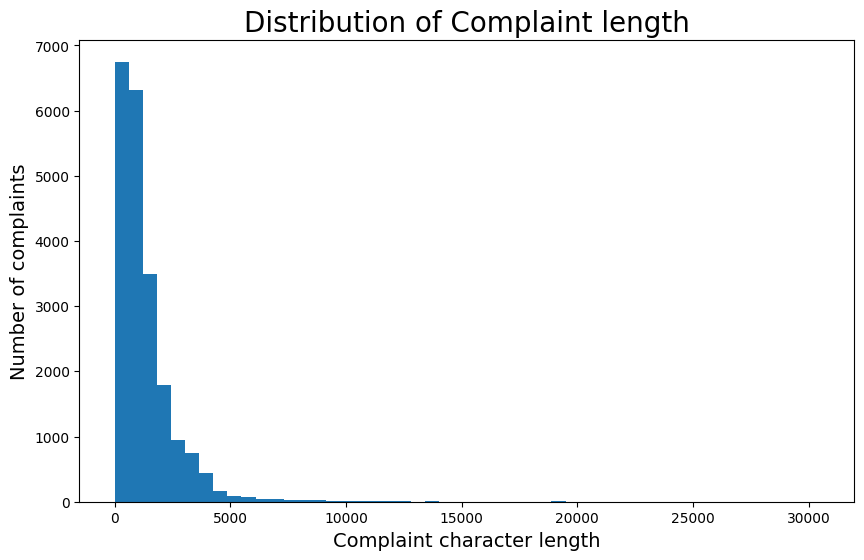

In [34]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_cleaned['complaint_length'], bins=50)
plt.title('Distribution of Complaint length', fontsize=20)
plt.ylabel('Number of complaints', fontsize=14)
plt.xlabel('Complaint character length', fontsize=14)
plt.show()

#### Word Cloud

In [35]:
stopwords = set(STOPWORDS)

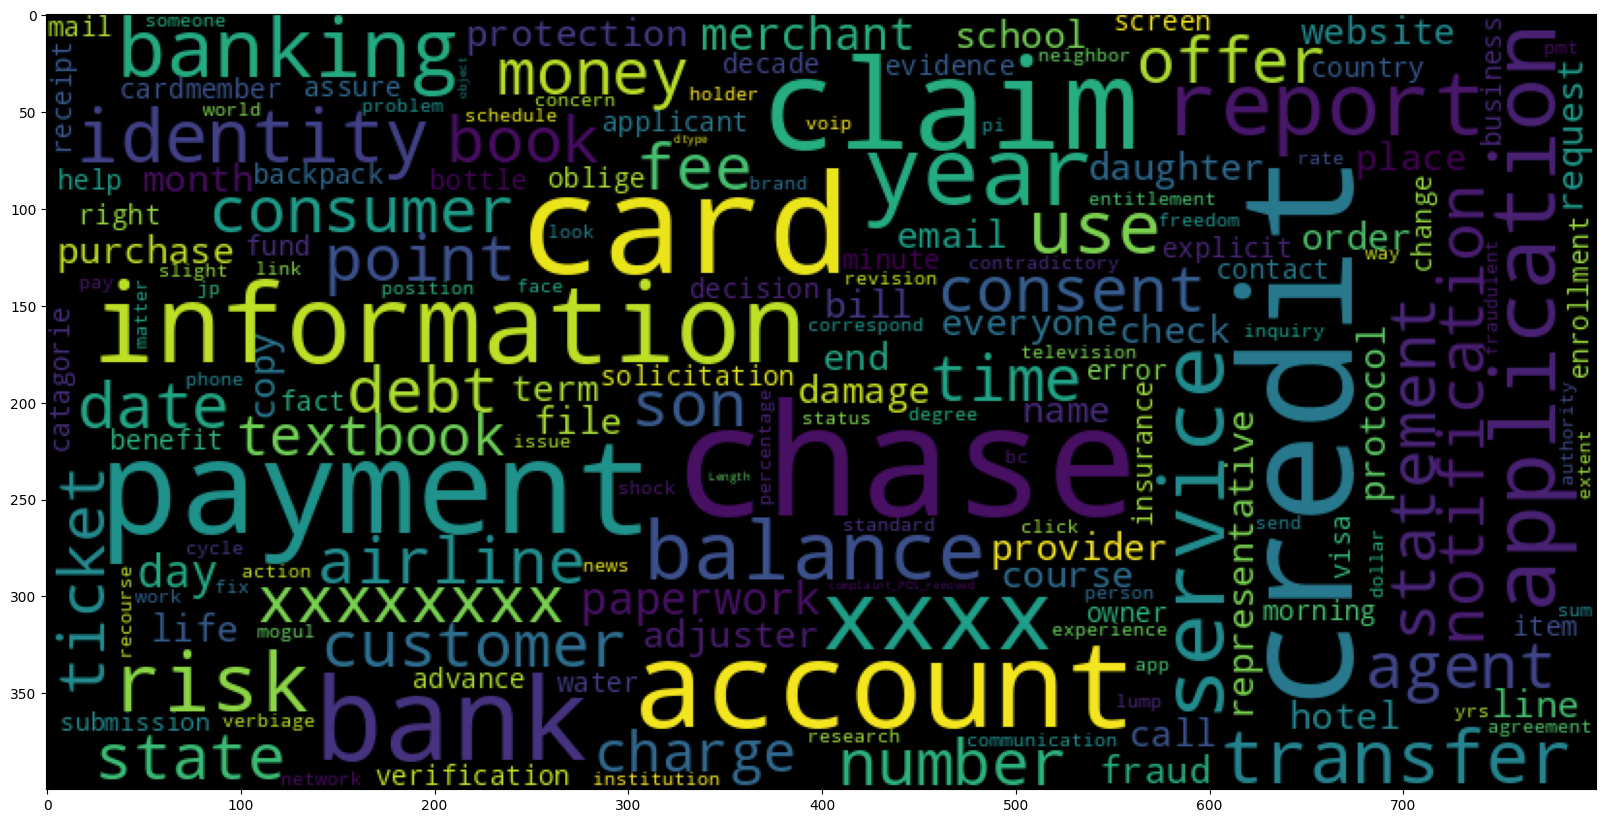

In [36]:
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400, stopwords = stopwords,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0).generate(str(df_cleaned['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)

#### Cleaning POS Tags

In [37]:
df_cleaned['complaint_clean'] = df_cleaned['complaint_POS_removed'].str.replace('-PRON-', '')
df_cleaned.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,complaint_clean
18467,i deposited a xxxx check from a xxxx bank written in us dollars i was told by the chase employee it would take weeks for it to clear even after checking with management in the back a week later i received a letter from chase stating it would take weeks i spoke with the payer on friday and was notified the check cleared their bank on xxxx it is a week after the check cleared and the funds are still not in my account the branch manager told me he cant help me that i have to speak with their executive office the executive office couldnt give me any answers so i requested to speak with a supervisor of course there was no supervisor available and i will have to wait up to hours to hear back from one of them this is totally unacceptable that they have tied my money up this long and i can not get any answers i am very very frustrated,check bank write dollar chase employee week check management back week letter chase state week payer friday check bank xxxx week check fund account branch manager tell executive office executive office supervisor course supervisor hour money answer,check bank dollar chase employee week check management week letter chase state week payer bank week check fund account manager office executive office supervisor course hour money answer,838,check bank dollar chase employee week check management week letter chase state week payer bank week check fund account manager office executive office supervisor course hour money answer
73268,xxxx has been noncompliant with removing the unverified account chase auto which has been deleted by xxxx and xxxx xxxx and xxxx have both completed their research and determined that chase auto was not established by myself but xxxx keeps verifying this accounts also when i called the company they responded that xxxx did not send them all of the verifying evidence to confirm each account is unverified,account auto xxxx research auto verify account company xxxx evidence account,account auto xxxx research auto account company evidence account,405,account auto xxxx research auto account company evidence account
15510,on xxxx xxxx xxxx of xxxx a lawyer for the plaintiffs in xxxx class actions pending in new york bankruptcy court confirmed monday that the xxxx banks agreed last week that within the next three months they ll either report this debt as included in bankruptcy and remove any negative information or will delete it entirely from credit reports the lawsuit filed in xxxx bankruptcy court in xxxx accused the banks of engineering what amounts to a subtle but ruthless debt collection tactic effectively holding borrowers credit reports hostage refusing to fix the mistakes unless people pay money for debts that they do not actually owe judge xxxx xxxx xxxx who is presiding over the cases has repeatedly refused the banks requests to throw out the lawsuits in xxxx when he refused to dismiss the case against jpmorgan he said the complaint sets forth a cause of action that chase is using the inaccuracy of its credit reporting on a systematic basis to further its business of selling debts and its buyer s collection of such debt as it is now xxxx xxxx more than the three months agreed upon in the settlement i am requesting immediate deletion of the zombie debt reported by chase that appears on my credit report,lawyer plaintiff class action pende york bankruptcy court confirm monday bank agree week month report debt include bankruptcy information credit report lawsuit file bankruptcy court xxxx bank engineering amount debt collection credit report hostage refuse mistake money debt judge case bank request lawsuit xxxx case jpmorgan complaint cause action chase inaccuracy credit reporting basis business debt buyer collection debt month settlement deletion debt report chase credit report,lawyer plaintiff class action pende york bankruptcy court confirm monday bank week month report debt bankruptcy in

#### Unigram, bigram and trigram analysis

In [38]:
def get_top_unigrams(text, n=None):
    vec = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [39]:
common_words = get_top_unigrams(df_cleaned['complaint_clean'].values.astype('U'), 30)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
unigram.head(10)

,unigram,count
0,account,41709
1,credit,34152
2,chase,33376
3,xxxx,30958
4,bank,28412
5,card,25689
6,payment,21170
7,time,16011
8,charge,14676
9,day,12976


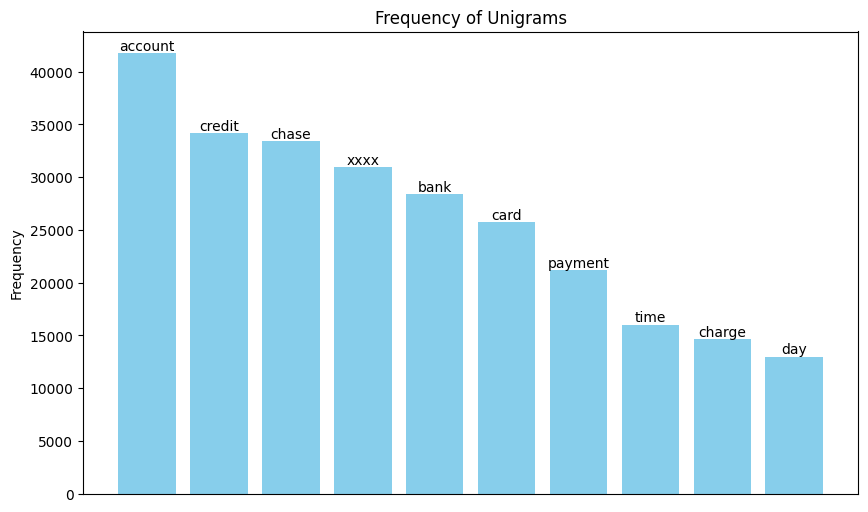

In [40]:
unigram_top_10 = unigram.sort_values('count', ascending=False).head(10)
plt.figure(figsize=(10, 6))
bars = plt.bar(unigram_top_10['unigram'], unigram_top_10['count'], color='skyblue')

# Annotate bars with values
for bar, freq in zip(bars, unigram_top_10['unigram']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.ylabel('Frequency')
plt.title('Frequency of Unigrams')
plt.xticks([])
plt.show()

In [41]:
def get_top_bigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [42]:
common_words = get_top_bigrams(df_cleaned['complaint_clean'].values.astype('U'), 30)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
bigram.head(10)

,bigram,count
0,credit card,12448
1,credit report,3998
2,xxxx xxxx,3640
3,customer service,3081
4,chase credit,2732
5,bank account,2640
6,account account,2311
7,chase account,2285
8,check account,2093
9,account bank,1998


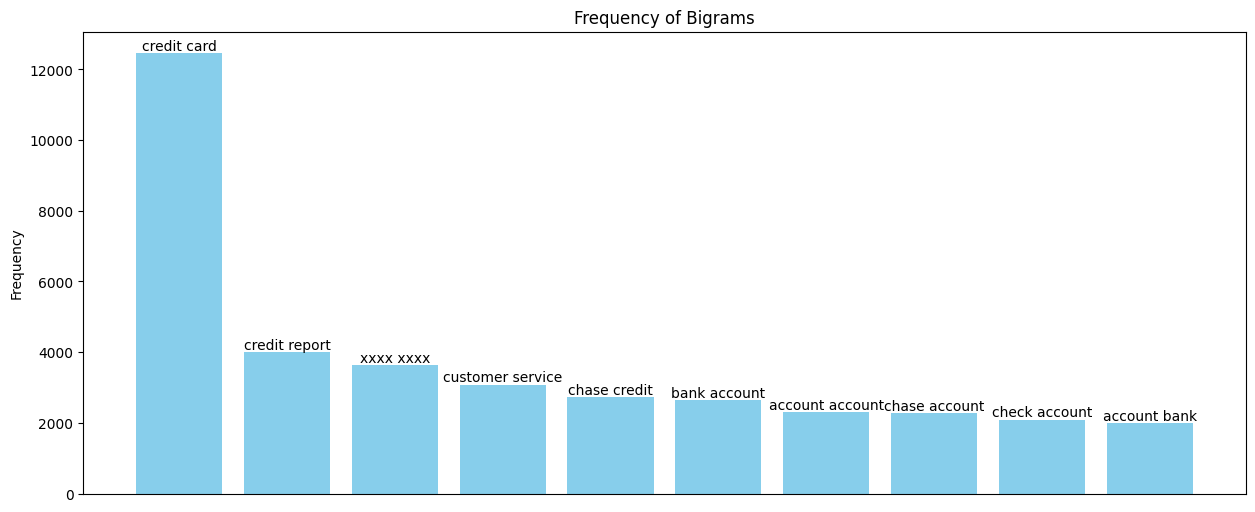

In [43]:
bigram_top_10 = bigram.sort_values('count', ascending=False).head(10)
plt.figure(figsize=(15, 6))
bars = plt.bar(bigram_top_10['bigram'], bigram_top_10['count'], color='skyblue')

# Annotate bars with values
for bar, freq in zip(bars, bigram_top_10['bigram']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.ylabel('Frequency')
plt.title('Frequency of Bigrams')
plt.xticks([])
plt.show()

In [44]:
def get_top_trigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [45]:
common_words = get_top_trigrams(df_cleaned['complaint_clean'].values.astype('U'), 30)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
trigram.head(10)

,trigram,count
0,chase credit card,1894
1,credit card company,1010
2,credit card account,875
3,credit card credit,595
4,credit card chase,529
5,credit report credit,476
6,charge credit card,447
7,account credit card,447
8,inquiry credit report,420
9,card credit card,418


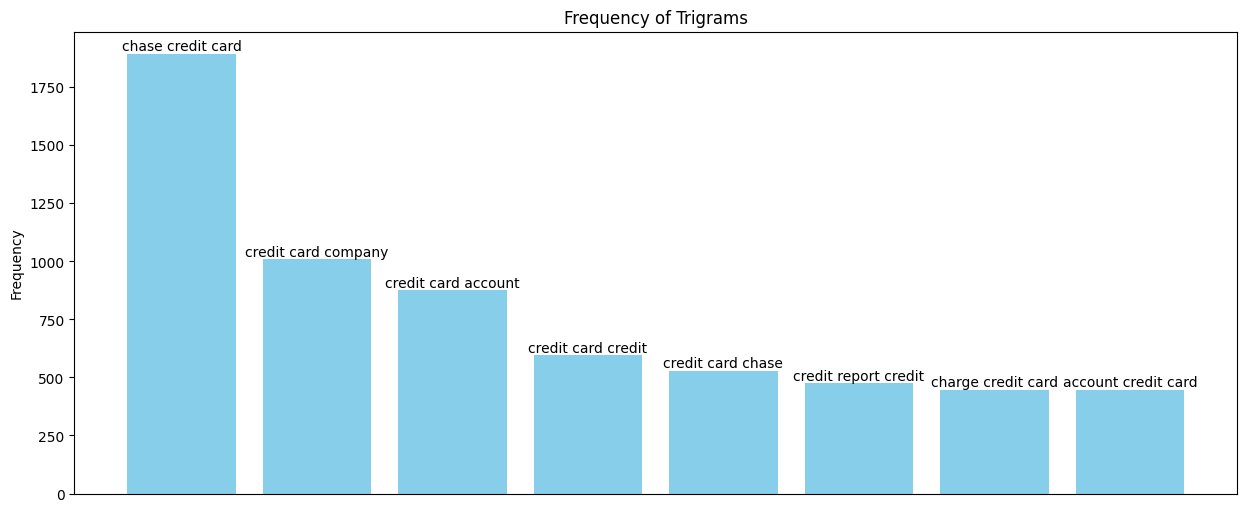

In [46]:
trigram_top_10 = trigram.sort_values('count', ascending=False).head(8)
plt.figure(figsize=(15, 6))
bars = plt.bar(trigram_top_10['trigram'], trigram_top_10['count'], color='skyblue')

# Annotate bars with values
for bar, freq in zip(bars, trigram_top_10['trigram']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.ylabel('Frequency')
plt.title('Frequency of Trigrams')
plt.xticks([])
plt.show()

#### Removing personal data marker from the text

In [47]:
def remove_allXX(text):
  return re.sub('[x]{2,}',"",text)

In [48]:
df_cleaned['complaint_clean'] = df_cleaned['complaint_clean'].swifter.apply(remove_allXX)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [49]:
df_cleaned['complaint_clean'] = df_cleaned['complaint_clean'].str.replace('xxxx','')

In [50]:
df_cleaned.sample(10)

complaints  \
4265                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

## Feature Engineering

#### TF-IDF Vectorization

In [51]:
tfidf_model = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [52]:
doc_term_mat = tfidf_model.fit_transform(df_cleaned['complaint_clean'])

## Model Building
### Topic Modelling

In [53]:
texts = df_cleaned['complaint_clean']
dataset = [d.split() for d in texts]

In [54]:
dictionary = Dictionary(dataset)

In [55]:
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

In [56]:
corpus = [dictionary.doc2bow(text) for text in dataset]

In [57]:
topic_nums = list(np.arange(5, 10, 1))

In [58]:
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

/home/eeshan/Documents/masters/06_NLP/venv/lib/python3.10/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in scalar divide

/home/eeshan/Documents/masters/06_NLP/venv/lib/python3.10/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning:

invalid value encountered in scalar divide



In [59]:
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


#### Manual Topic Modelling

In [60]:
num_topics = 5

In [61]:
nmf_model = NMF(n_components=5, random_state=40)

In [62]:
nmf_model.fit(doc_term_mat)
len(tfidf_model.get_feature_names_out())

5798

In [63]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf_model.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'customer', 'claim', 'business', 'number', 'transaction', 'branch', 'day', 'chase', 'deposit', 'fund', 'check', 'money', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'application', 'letter', 'debt', 'limit', 'information', 'score', 'company', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['history', 'car', 'year', 'mortgage', 'pay', 'credit', 'date', 'auto', 'time', 'day', 'fee', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['day', 'company', 'time', 'statement', 'service', 'claim', 'purchase', 'fraud', 'chase', 'merchant', 'dispute', 'transaction', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['foreclosure', 'document', 'sale', 'bank', 'house', 'time', 'letter', 'rate', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [64]:
topic_results = nmf_model.transform(doc_term_mat)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [65]:
df_cleaned['topic'] = topic_results.argmax(axis=1) 

In [66]:
df_cleaned.head(10)

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,complaint_clean,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,469,morning name bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent date agent information order account change date xxxxxxxx consent xxxx agent,334,card agent date agent information order account change date consent agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,card report application identity consent service credit identity applicant,report application identity consent service credit identity applicant,209,report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx ticket offer ticket card information offer minute screen decision bank chase bank notification screen chase representative application state information xxxx offer credit offer account statement use ticket account application representative oblige put application explicit request application chase chase fact credit account name report credit report chase information credit report application error,book xxxx ticket offer ticket card information minute screen decision bank bank notificat

In [67]:
df_cleaned.groupby('topic').head(5).sort_values('topic')

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,complaint_clean,topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,469,morning name bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,son chase account fund bank account money son money bank money son call chase time check owner country time date check number claim number chase,452,son chase account fund bank account money son money bank money son call chase time check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to 

In [68]:
Topic_names = {
    0:"Bank Account services",
    1:"Credit card or prepaid card", 
    2:"Others",
    3:"Theft/Dispute Reporting",
    4:"Mortgage/Loan"}

In [69]:
df_cleaned['Topic'] = df_cleaned['topic'].map(Topic_names)

In [70]:
df_cleaned.sample(10).sort_values('topic')

complaints  \
40810  direct deposit payroll from my company xxxx xxxx xxxx xxxx xxxx of xxxx texas was put on a hour restriction i was told the restriction was due to the fact that the it department did nt know how to allow any deposit or transaction to occur after a settlement check had been deposited the day before into my checking account before the direct deposit was to take affect thursday xxxxxxxx i drove to my institution which is jpmorgan chase bank i deposited a settlement check that i have received from a settlement the entire check was in the amount of and some change after i deposited that settlement check i also took out an additional out of my checking account they allowed to be withdrawn at that time out of my checking account however i was xxxx dollars overdrawn from the checking account i assumed i had requested such a small amount from the settlement check of only dollars out of the that they went ahead and allowed me the dollars cash and that s why they allowed it to go through the settlement check or clear from the settlement check not the overdrawn checking account the problem that i have is the fact that my direct deposit from my company which i have directly deposited my payroll checks from the company for the last three years did not clear jpmorgan chase bank until saturday xxxxxxxx the direct deposit payroll check should have cleared on friday xxxxxxxx not saturday xxxxxxxx i always get paid at midnight the night before so my checks clear directly on the night before i get paid so the check should have gone in actually at midnight on thursday xxxxxxxx at midnight which would have technically been xxxxxxxx at xxxx xxxx midnight which would have been the xxxxxxxx however because thursday night i had deposited the settlement check the it department put a restriction on my account or somebody else put a restriction on my account just because i had made a deposit the day before in such a large amount the entire account had restriction and the entire account would not allow for any deposit any transaction of any kind to go through a deposit or not so i called and asked what the problem was and i called and spoke with the manager of the accounts department and i was told that the account was on restriction and i asked what for and i wanted to speak with a supervisor a supervisor got on the phone and said there was nothing they could do about it because the account was on restriction what i do nt understand is why my payroll check that i was waiting on to clear the bank that i worked for that has been directly deposited into that account have anything to do with that settlement check that got deposited i was not asking to take the money out i was nt asking for the i was nt asking to take away or withdraw any funds other than the dollars i got thursday night i was wanting to know why it was my payroll check had not been reflected on to my account and it was a direct deposit and has been for the last three years and they stated i was on restriction because of a deposit the night before i need someone to understand that this is completely ludicrous unethical banking practices why are you going to restrict someone s payroll direct deposit just because the day before they deposited money it makes absolutely no sense whatsoever to punish the consumer and not allow them to have their money and put them in a financial crisis they have no idea what they did to me for that hours i am not asking for anything to be done other than i need someone to be aware of these unethical practices you can not allow a bank to get away with that i have been a customer with jpmorgan chase bank since xxxxxxxx and like i told them on the phone when i spoke with them on friday xxxxxxxx i will no longer be a customer of theirs as soon as i have all my ducks in a row i most likely will change banks and go to some other financial institution because of this situation i find it absolutely ludicrous and unethical that a financial institution ha

### Supervised Model Building
In order to predict new complaints to related topics 

In [71]:
Topic_names = { 
    "Bank Account services": 0,
    "Credit card or prepaid card": 1,
    "Others": 2,
    "Theft/Dispute Reporting": 3,
    "Mortgage/Loan": 4}

In [72]:
df_cleaned.sample(10)

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,complaint_clean,topic,Topic
4017,i received a check for the value of i believe this to have been a fraudulent check but did not know at the time i deposited the check i deposited the check into my chase checking account on xxxxxxxxxxxx i was informed by the scammer on xxxxxxxxxxxx that i needed to withdraw of the money that i deposited and submit that money into another chase business account i can provide the name on the account and the account number upon request i believe this account is directly associated with the scam i submit the into the account provided on xxxxxxxxxxxx on xxxxxxxxxxxx i received a notification from chase stating that my account was overdrawn by because the check for had bounced i called chase bank to try to figure out what had happened and spoke to several different customer service representatives the last representative i spoke to instructed me to go to the chase bank branch i made the deposit and instruct the bank teller that i worked with to contact a number that they provided me upon arriving at the chase branch that i made the deposit at they informed me that they would not under any circumstances call that number and that there was nothing that i could do in this situation aside from paying the negative balance on my account i have submit a police report xxxx and can provide a copy of the report upon request,check value check time check check check account xxxxxxxxxxxx scammer xxxxxxxxxxxx money money chase business account name account account number request account scam account xxxxxxxxxxxx xxxxxxxxxxxx notification chase state account check bounce bank customer service representative chase bank branch deposit bank teller number chase branch deposit circumstance call number nothing situation balance account police report xxxx copy report request,check value check time check check account xxxxxxxxxxxx scammer xxxxxxxxxxxx money money chase business account name account account number request account scam account xxxxxxxxxxxx xxxxxxxxxxxx notification chase state account check bounce bank customer service chase bank deposit bank number chase deposit circumstance call number nothing situation balance account report xxxx copy report request,1329,check value check time check check account scammer money money chase business account name account account number request account scam account notification chase state account check bounce bank customer service chase bank deposit bank number chase deposit circumstance call number nothing situation balance account report copy report request,0,Bank Account services
43775,case number xxxx i returned item via xxxx xxxx shipping label tracking xxxx the return was delivered on xxxxxxxxxxxx however i never got refund i contacted and faxed all info to chase twice however they are not working on it,case number xxxx track return xxxxxxxxxxxx refund info,case number xxxx track return xxxxxxxxxxxx refund info,224,case number track return refund info,3,Theft/Dispute Reporting
32791,i noticed inquiries that i didnt not make,inquiry,inquiry,41,inquiry,1,Credit card or prepaid card
3615,xxxxxxxx check xxxx for deposited into client trust xxxx account ending in xxxx xxxxxxxx i discovered possible fraud on business operations account ending in xxxx i called chase to have account frozen this account was no longer able to be used at all i went to local branch to have operations account xxxx closed and open a new one the new operations account was opened and ends in xxxx xxxxxxxx the check xxxx was moved from old account xxxx to new account xxxx along with all other funds held in account xxxx on that same date another was deposited i was unable to see the deposit slip or check image i called my local branch to quickly verify that the funds were there as it was odd for me not to be able to view the deposit slip or check image i also contacted the client from whom i expected a deposit in the amount of xxxx

#### Vectorizing the training data

In [73]:
training_data = df_cleaned[['complaints', 'topic']]

In [74]:
training_data = training_data.groupby('topic').sample(1000)

In [75]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaints'])

In [76]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.topic,
                                                    test_size=0.25, random_state=42)

In [78]:
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of test_data: {X_test.shape}")
print(f"Shape of test_labels: {y_test.shape}")

Shape of training data: (3750, 16935)
Shape of training labels: (3750,)
Shape of test_data: (1250, 16935)
Shape of test_labels: (1250,)


### Model Training

In [79]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
  
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    
    return

In [80]:
# Logistic regression
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

In [81]:
# Calculate F1 Score of tuned model 
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.8848888707162565

In [82]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga') 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

/home/eeshan/Documents/masters/06_NLP/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [83]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9142985281490356

In [84]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.91      0.92      0.91       266
Credit card or prepaid card       0.91      0.91      0.91       242
                     Others       0.95      0.95      0.95       236
    Theft/Dispute Reporting       0.89      0.87      0.88       264
              Mortgage/Loan       0.92      0.93      0.93       242

                   accuracy                           0.91      1250
                  macro avg       0.92      0.92      0.92      1250
               weighted avg       0.91      0.91      0.91      1250



In [85]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.88,0.91


In [86]:
# Decision Tree 

# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

In [87]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7390823283517226

In [88]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)

clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

In [89]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.7703074179700358

In [90]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.74      0.76      0.75       266
Credit card or prepaid card       0.79      0.79      0.79       242
                     Others       0.82      0.81      0.82       236
    Theft/Dispute Reporting       0.72      0.70      0.71       264
              Mortgage/Loan       0.79      0.81      0.80       242

                   accuracy                           0.77      1250
                  macro avg       0.77      0.77      0.77      1250
               weighted avg       0.77      0.77      0.77      1250



In [91]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.88,0.91
1,Decision Tree,0.74,0.77


In [92]:
# Random Forest 
# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [93]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8176298687737917

In [94]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)

clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

In [95]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.81441684601125

In [96]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.80      0.81       266
Credit card or prepaid card       0.82      0.84      0.83       242
                     Others       0.82      0.87      0.85       236
    Theft/Dispute Reporting       0.81      0.73      0.77       264
              Mortgage/Loan       0.80      0.85      0.82       242

                   accuracy                           0.82      1250
                  macro avg       0.82      0.82      0.82      1250
               weighted avg       0.82      0.82      0.81      1250



In [97]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.88,0.91
1,Decision Tree,0.74,0.77
2,Random Forest,0.82,0.81


In [98]:
# Naive Baiyes  ( Optional)

model_name = 'NAIVE BAYES'
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

In [99]:
# Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.7824466835065546

In [100]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

In [101]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned

0.7715646731771576

In [102]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name)

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.83      0.81       266
Credit card or prepaid card       0.81      0.67      0.73       242
                     Others       0.69      0.75      0.72       236
    Theft/Dispute Reporting       0.76      0.79      0.77       264
              Mortgage/Loan       0.81      0.81      0.81       242

                   accuracy                           0.77      1250
                  macro avg       0.77      0.77      0.77      1250
               weighted avg       0.77      0.77      0.77      1250



In [103]:
# Update the summary table
summary.loc[len(summary.index)] = ['Naive Bayes', round(f1_nb, 2), round(f1_nb_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.88,0.91
1,Decision Tree,0.74,0.77
2,Random Forest,0.82,0.81
3,Naive Bayes,0.78,0.77


## Model Infernece

In [104]:
def get_topic_name(i):
    return [k for k, v in Topic_names.items() if v==y_pred_lr_tuned[i]][0]

In [105]:
feature_names = count_vect.get_feature_names_out()

In [106]:
top_words_all, topic_names = [], []
for i in range(X_test.shape[0]):
    x_test_ = X_test[i]
    top_word_idx = np.argsort(x_test_.toarray()[0])[::-1]
    top_words = feature_names[top_word_idx[:10]]
    top_words_all.append(str(top_words))
    topic_names.append(get_topic_name(i))
    # break
top_words_all_df = pd.DataFrame({'Top_Words': top_words_all, 'Topic_Names': topic_names})

In [107]:
top_words_all_df.sample(10)

,Top_Words,Topic_Names
209,['the' 'to' 'completed' 'bank' 'inspection' 'percent' 'check' 'area'\n 'work' 'xxxx'],Bank Account services
456,['off' 'it' 'and' 'paid' 'in' 'full' 'did' 'get' 'feeinterest' 'monmey'],Others
583,['the' 'replaced' 'materials' 'roof' 'mold' 'contractor' 'rotten' 'honor'\n 'wood' 'and'],Theft/Dispute Reporting
184,['trial' 'payment' 'due' 'of' 'amount' 'construed' 'loan' 'modification'\n 'dated' 'period'],Others
239,['read' 'written' 'to' 'pages' 'expected' 'little' 'the' 'drift'\n 'descends' 'decipher'],Mortgage/Loan
455,['inquiry' 'banki' 'plunge' 'disputed' 'notice' 'amazoncom' 'the' 'this'\n 'results' 'through'],Credit card or prepaid card
372,['redeem' 'cash' 'points' 'accumulated' 'reward' 'worth' 'advance'\n 'rewards' 'program' 'refuse'],Credit card or prepaid card
1244,['xxxx' 'discharge' 'until' 'resume' 'payments' 'the' 'agent' 'in' 'to'\n 'position'],Others
844,['box' 'deposit' 'treasurey' 'the' 'local' 'library' 'abandoned'\n 'secretary' 'jp' 'morgan'],Bank Account services
519,['judgment' 'default' 'bills' 'postponing' 'was' 'levy' 'the' 'now' 'debt'\n 'courts'],Bank Account services
